<a href="https://colab.research.google.com/github/Natalia409634/Grupo7-practica2-ML/blob/main/G7_P2_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

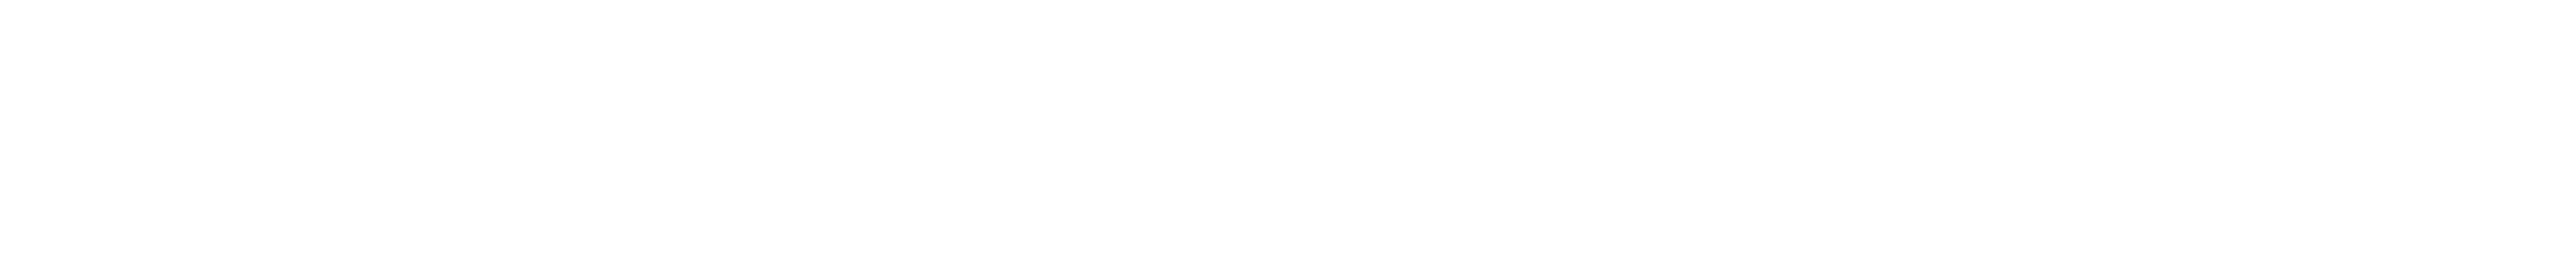

# **PRÁCTICA 2: PREDICCIÓN DE ABANDONO DE EMPLEADOS**

Aprendizaje Automático - Grupo 7

*   Andrés Felipe Camacho Martínez - 100408821
*   Natalia Jiménez Barrigüete - 100409634


# Librerías

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pickle
import os

# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import RandomizedSearchCV, KFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


# Lectura de Datos

Los datos están en formato 'pkl'

In [46]:
# Carga el archivo pkl en un DataFrame de Pandas
data_df = pd.read_pickle('/content/drive/MyDrive/Aprendizaje Automático/practica 2/datos_grupos/attrition_available_7.pkl')

Edición visual de los datos

In [47]:
def set_frame_style(df, caption=""):
    """Helper function to set dataframe presentation style.
    """
    return df.style.background_gradient(cmap='Blues').set_caption(caption).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'darkblue'),
        ('font-size', '18px'),
        ('font-weight','bold')
    ]}])

# EDA Simplificado

Se trata de un **problema de clasificación**, ya que la variable de salida que se espera del modelo es categórica, es decir, se espera que el modelo prediga si un empleado abandonará o no la empresa en un futuro cercano

## 1. Análisis de variables

In [48]:
data_df.head()

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
1,7.315971,13.0,2.0,NaN,3.0,2.0,NaN,31.0,Yes,Travel_Frequently,...,0.0,Y,NaN,NaN,1,6.0,3.0,5.0,1.0,4.0
6,6.450877,17.0,3.0,4.0,1.0,3.0,1.0,28.0,Yes,Travel_Rarely,...,2.0,Y,20.0,NaN,1,5.0,2.0,0.0,0.0,0.0
13,8.871421,14.0,2.0,3.0,1.0,2.0,2.0,47.0,Yes,NaN,...,1.0,Y,NaN,8.0,2,10.0,4.0,10.0,9.0,9.0
28,10.713066,6.0,2.0,3.0,4.0,3.0,1.0,44.0,Yes,Travel_Frequently,...,3.0,Y,14.0,8.0,1,19.0,2.0,1.0,0.0,0.0
30,9.662808,11.0,2.0,NaN,1.0,2.0,NaN,26.0,Yes,Travel_Rarely,...,2.0,Y,NaN,8.0,0,5.0,5.0,3.0,0.0,2.0


In [49]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 1 to 4409
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hrs                      3588 non-null   float64
 1   absences                 3663 non-null   float64
 2   JobInvolvement           3542 non-null   float64
 3   PerformanceRating        3684 non-null   float64
 4   EnvironmentSatisfaction  4385 non-null   float64
 5   JobSatisfaction          3484 non-null   float64
 6   WorkLifeBalance          3526 non-null   float64
 7   Age                      3678 non-null   float64
 8   Attrition                4410 non-null   object 
 9   BusinessTravel           3452 non-null   object 
 10  Department               3553 non-null   object 
 11  DistanceFromHome         3569 non-null   float64
 12  Education                3676 non-null   float64
 13  EducationField           3441 non-null   object 
 14  EmployeeCount           

El conjunto de datos proporcionado tiene 30 atributos, los cuales adoptan un formato: 'float64', 'int64' y 'object'.

Hemos detectado una anomalía y es que la variable "StockOptionLevel" en nuestro dataset es de tipo "int64" cuando según la documentación debería ser de tipo "float64". De cara al posterior tratamiento de las Missing Values hemos decidio transformarla a tipo "float64".

In [50]:
data_df["StockOptionLevel"] = data_df["StockOptionLevel"].astype(float)

In [51]:
cols = data_df.columns.to_list()

display(set_frame_style(data_df[cols].head(),'Primeros'))

display(set_frame_style(data_df[cols].describe(),'Resumen de estadistica'))

display(set_frame_style(data_df[cols].isna().any().to_frame().transpose(), 'Columnas con valor nulo'))

display(set_frame_style(data_df[cols].nunique().to_frame().rename({0:'Numero de valores únicos'}, axis=1).transpose(), 'Valores únicos en cada variable'))

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
1,7.315971,13.000000,2.000000,nan,3.000000,2.000000,nan,31.000000,Yes,Travel_Frequently,Research & Development,10.000000,1.000000,Life Sciences,1.000000,2,Female,nan,Research Scientist,Single,41890.000000,0.000000,Y,nan,nan,1.000000,6.000000,3.000000,5.000000,1.000000,4.000000
6,6.450877,17.000000,3.000000,4.000000,1.000000,3.000000,1.000000,28.000000,Yes,Travel_Rarely,nan,11.000000,2.000000,Medical,1.000000,7,Male,2.000000,nan,Single,58130.000000,2.000000,Y,20.000000,nan,1.000000,5.000000,2.000000,0.000000,0.000000,0.000000
13,8.871421,14.000000,2.000000,3.000000,1.000000,2.000000,2.000000,47.000000,Yes,nan,Research & Development,1.000000,1.000000,Medical,1.000000,14,Male,1.000000,Research Scientist,Married,57620.000000,1.000000,Y,nan,8.000000,2.000000,10.000000,4.000000,10.000000,9.000000,9.000000
28,10.713066,6.000000,2.000000,3.000000,4.000000,3.000000,1.000000,44.000000,Yes,Travel_Frequently,Research & Development,1.000000,2.000000,Medical,1.000000,29,Male,2.000000,Research Scientist,Divorced,103330.000000,3.000000,Y,14.000000,8.000000,1.000000,19.000000,2.000000,1.000000,0.000000,0.000000
30,9.662808,11.000000,2.000000,nan,1.000000,2.000000,nan,26.000000,Yes,Travel_Rarely,Research & Development,4.000000,nan,Medical,1.000000,31,Male,3.000000,Research Scientist,nan,nan,2.000000,Y,nan,8.000000,0.000000,5.000000,5.000000,3.000000,0.000000,2.000000


,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
count,3588.000000,3663.000000,3542.000000,3684.000000,4385.000000,3484.000000,3526.000000,3678.000000,3569.000000,3676.000000,3561.000000,4410.000000,3566.000000,3448.000000,3646.000000,3457.000000,3465.000000,4410.000000,3514.000000,3700.000000,3628.000000,3652.000000,3665.000000
mean,7.325269,12.731095,2.723038,3.155266,2.723603,2.733639,2.758934,36.942360,9.177641,2.909412,1.000000,2205.500000,2.046831,65417.700116,2.715030,15.244721,8.000000,0.793878,11.268355,2.795676,6.995039,2.204272,4.116235
std,1.332110,5.531700,0.718360,0.362207,1.092756,1.095605,0.701183,9.124196,8.093058,1.023644,0.000000,1273.201673,1.094571,47530.589620,2.511696,3.682925,0.000000,0.851883,7.785224,1.290212,6.084324,3.244261,3.557025
min,5.416880,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10090.000000,0.000000,11.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.295553,8.000000,2.000000,3.000000,2.000000,2.000000,2.000000,30.000000,2.000000,2.000000,1.000000,1103.250000,1.000000,29290.000000,1.000000,12.000000,8.000000,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000
50%,7.018052,13.000000,3.000000,3.000000,3.000000,3.000000,3.000000,36.000000,7.000000,3.000000,1.000000,2205.500000,2.000000,49330.000000,2.000000,14.000000,8.000000,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000
75%,7.912442,17.000000,3.000000,3.000000,4.000000,4.000000,3.000000,43.000000,14.000000,4.000000,1.000000,3307.750000,3.000000,84120.000000,4.000000,18.000000,8.000000,1.000000,15.000000,3.000000,9.000000,3.000000,7.000000
max,10.937261,24.000000,4.000000,4.000000,4.000000,4.000000,4.000000,60.000000,29.000000,5.000000,1.000000,4410.000000,5.000000,199990.000000,9.000000,25.000000,8.000000,3.000000,40.000000,6.000000,40.000000,15.000000,17.000000


,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,False,True,True,True,True,True,True,False,True,True,False,True,True,True,True,True


,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
Numero de valores únicos,3585,24,4,2,4,4,4,43,2,3,3,29,5,6,1,4410,2,5,9,3,1337,10,1,15,1,4,40,7,37,16,18


## 2. Eliminación de variables

Procedemos a eliminar las variables constantes, es decir, cuya Desviación Típica (std) es igual a 0

In [52]:
data_df = data_df.drop(['Over18'], axis=1)

In [53]:
data_df = data_df.drop(['StandardHours'], axis=1)

In [54]:
data_df = data_df.drop(['EmployeeCount'], axis=1)

Por otro lado, eliminamos variables que consideramos innecesarias

In [55]:
data_df = data_df.drop(['EmployeeID'], axis=1)

## 3. Missing Values

Identificación y proporción de Missing Values

In [ ]:
missing_values_count = data_df.isnull().sum().sort_values(ascending=False)
prop_miss = data_df.isna().mean().sort_values(ascending=False)

missing_props_df = pd.concat([missing_values_count, prop_miss], axis=1, keys=['Missing Values Count', 'Proportion Missing'])

print(missing_props_df)

Aquí se puede encontrar el numero de datos faltantes ordenadors de mayor a menos por atributo. Las columnas más incompletas son EducationField, MonthlyIncome Y BusinessTravel. **menos datos = menos precisión**

Asimismo, tambien se muestra la proporción de valores faltantes en cada columna del DataFrame.

Por ejemplo, para la columna "hrs" la proporción de valores faltantes es del 18.64%, lo que significa que aproximadamente el 18.64% de los valores en esa columna están faltando. De manera similar, para la columna "absences", la proporción de valores faltantes es del 16.94%, lo que significa que alrededor del 16.94% de los valores en esa columna están faltando.

También se puede observar como los atributos 'Attrition' y 'StockOptionLevel' tienen un valor de 0.00, lo que implica que estan presentes todos los valores 

### Clasificación de variables

In [ ]:
data_type = data_df.dtypes
print(data_type)

El conjunto de datos tras el tratamiento tiene 26 atributos, con datos de tipo: 'float64' y 'object'

In [69]:
cols = data_df.columns.to_list()
display(set_frame_style(data_df[cols].describe(),'Resumen de estadistica'))
display(set_frame_style(data_df[cols].nunique().to_frame().rename({0:'Numero de valores únicos'}, axis=1).transpose(), 'Valores únicos en cada variable'))

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
count,3588.000000,3663.000000,3542.000000,3684.000000,4385.000000,3484.000000,3526.000000,3678.000000,3569.000000,3676.000000,3566.000000,3448.000000,3646.000000,3457.000000,4410.000000,3514.000000,3700.000000,3628.000000,3652.000000,3665.000000
mean,7.325269,12.731095,2.723038,3.155266,2.723603,2.733639,2.758934,36.942360,9.177641,2.909412,2.046831,65417.700116,2.715030,15.244721,0.793878,11.268355,2.795676,6.995039,2.204272,4.116235
std,1.332110,5.531700,0.718360,0.362207,1.092756,1.095605,0.701183,9.124196,8.093058,1.023644,1.094571,47530.589620,2.511696,3.682925,0.851883,7.785224,1.290212,6.084324,3.244261,3.557025
min,5.416880,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,18.000000,1.000000,1.000000,1.000000,10090.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.295553,8.000000,2.000000,3.000000,2.000000,2.000000,2.000000,30.000000,2.000000,2.000000,1.000000,29290.000000,1.000000,12.000000,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000
50%,7.018052,13.000000,3.000000,3.000000,3.000000,3.000000,3.000000,36.000000,7.000000,3.000000,2.000000,49330.000000,2.000000,14.000000,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000
75%,7.912442,17.000000,3.000000,3.000000,4.000000,4.000000,3.000000,43.000000,14.000000,4.000000,3.000000,84120.000000,4.000000,18.000000,1.000000,15.000000,3.000000,9.000000,3.000000,7.000000
max,10.937261,24.000000,4.000000,4.000000,4.000000,4.000000,4.000000,60.000000,29.000000,5.000000,5.000000,199990.000000,9.000000,25.000000,3.000000,40.000000,6.000000,40.000000,15.000000,17.000000


,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
Numero de valores únicos,3585,24,4,2,4,4,4,43,2,3,3,29,5,6,2,5,9,3,1337,10,15,4,40,7,37,16,18


In [66]:
count = {'Categóricos': [], 'Ordinales': [], 'Numéricos': []}
for nombre, valor in data_type.items():
  if valor == 'object': count['Categóricos'].append(nombre)
  if valor == 'float64':
    if (data_df[nombre].min() >= 0 and data_df[nombre].min() <= 1) and (data_df[nombre].max() >= 3 and data_df[nombre].max() <= 5):
      count['Ordinales'].append(nombre)
    else:
      count['Numéricos'].append(nombre)

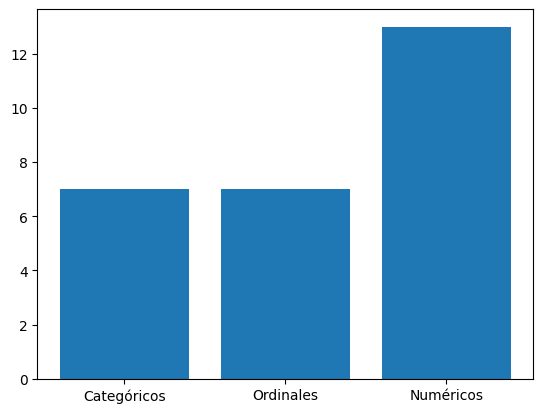

In [68]:
claves = list(count.keys())
cantidades = [len(valores) for valores in count.values()]
plt.bar(claves, cantidades)
plt.show()

### Tratamiento de Missing Values

Sustituiremos los Missing Values por la media en las variables numéricas, por la moda en las categóricas y en las ordinales.

Contamos con variables categóricas binomiales, "Gender" y "Atrittion", las cuales transformaremos para que tomen valores o bien 0 o bien 1. 

In [72]:
for col in count['Numéricos']:
  mean = np.nanmean(data_df[col])
  data_df.loc[np.isnan(data_df[col]), col] = mean

In [73]:
for col in count['Ordinales']:
  mode = data_df[col].mode()[0]
  data_df.loc[data_df[col].isnull(), col] = mode

In [74]:
for col in count['Categóricos']:
  mode = data_df[col].mode()[0]
  data_df.loc[data_df[col].isnull(), col] = mode

#### Variables categóricas binomiales "Gender" y "Atrittion"

In [76]:
new_atrittion = {'No': 0, 'Yes': 1}
new_gender = {'Male': 0, 'Female': 1}

data_df['Attrition'] = data_df['Attrition'].replace(new_atrittion)
data_df['Gender'] = data_df['Gender'].replace(new_gender)

#### Resto de variables categóricas, aplicación de One Hot Encoder

In [78]:
from sklearn.preprocessing import OneHotEncoder

columns_to_encode = ['BusinessTravel', 'Department', 'EducationField', 'JobRole', 'MaritalStatus']

encoder = OneHotEncoder()

encoded_data = encoder.fit_transform(data_df[columns_to_encode])

categories = encoder.categories_

new_columns = []
for i, column in enumerate(columns_to_encode):
    for category in categories[i]:
        new_columns.append(f"{column}_{category}")

encoded_data = encoded_data.toarray()
encoded_df = pd.DataFrame(encoded_data, columns=new_columns)

data_df = pd.concat([data_df.drop(columns_to_encode, axis=1), encoded_df], axis=1)

## 4. ¿El problema está balanceado?

In [82]:
# Número de muestras por clase
data_df.Attrition.value_counts().sort_index()

0    3699
1     711
Name: Attrition, dtype: int64

Tenemos 3699 muestras que no han dejado la empresa y 711 que sí han dejado la empresa. Por lo que el problema se encuentra desbalanceado.

## 5. Separación en conjuntos

Seguirá la siguiente distribución:

*   Cojunto de entrenamiento [X_train, y_train]
*   Conjunto de validación [X_valid, y_valid]
*   Conjunto de test [X_test, y_test]

In [101]:
from sklearn.model_selection import train_test_split

X = data_df.drop('Attrition', axis=1)
y = data_df['Attrition']

X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.67, random_state=7)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=7)

Realizamos la separación en conjuntos empleando train_test_split siguiendo las recomendaciones del profesor dadas en clase.

# Construcción de modelos

Construcción de modelos: para esta práctica usaremos
LogisticRegression como método base (sin ajustar hiper-parámetros) y Boosting
como método avanzado (ajustando hiper-parámetros), a elegir. Es importante
realizar los preprocesos que los datos necesiten, usando preferentemente
pipelines. Como método de boosting, se puede elegir uno de entre los métodos de
boosting disponibles en scikit-learn. Si además se usa uno de entre las librerías
externas xgboost, lightgbm o catboost, se pueden sacar +0.35 puntos adicionales.

## Logistic Regression

Los parámetros más importantes de la implantación de sklearn (`LogisticRegression`) son:

- `penalty`: El tipo de aplicación de regularización.
- `C`: (por defecto 1.0) Inverso de la fuerza de regularización; Valores más pequeños especifican una regularización más fuerte.
- `solver`: Algoritmo a utilizar en el problema de optimización.

In [89]:
# Probamos el modelo sin aplicar ninguna regularización y con los parámetros por efecto
# ==============================================================================
scaler = StandardScaler()
lr = LogisticRegression(penalty='none', random_state = 7)

pipe_scale_lr = Pipeline([
    ('scale', scaler),
    ('lr', lr)])

# Entrenamiento del modelo
# ==============================================================================
cv = KFold(n_splits=5, shuffle=True, random_state = 42 )
scores = cross_val_score(pipe_scale_lr, X_train, y_train, scoring='accuracy', cv = cv)
print(f"All the accuracies are: {scores}")
print(f"And the average crossvalidation accuracy is: {scores.mean():.2f} +- {scores.std():.2f}")

All the accuracies are: [0.70665323 0.68920283 0.68314834 0.69122099 0.67003027]
And the average crossvalidation accuracy is: 0.69 +- 0.01


In [90]:
param_grid = [{'lr__penalty': ['l1', 'l2', 'elascticnet'],
               'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
               'lr__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}]


inner = KFold(n_splits=3, shuffle=True, random_state=42)

#budget = 40
# Cross-validation (3-fold) para la búsqueda de hiper-parámetros
clf = GridSearchCV (estimator  = pipe_scale_lr,
                    param_grid = param_grid,
                    scoring='accuracy',
                    cv=inner,
                    refit=True,
                    n_jobs=-1,
                    verbose=1,
                    return_train_score=True)

np.random.seed(42)

clf.fit(X=X_train, y=y_train)

Fitting 3 folds for each of 105 candidates, totalling 315 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(penalty='none',
                                                           random_state=7))]),
             n_jobs=-1,
             param_grid=[{'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'lr__penalty': ['l1', 'l2', 'elascticnet'],
                          'lr__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                         'sag', 'saga']}],
             return_train_score=True, scoring='accuracy', verbose=1)

In [91]:
resultados = pd.DataFrame(clf.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head()

,param_lr__C,param_lr__penalty,param_lr__solver,mean_test_score,std_test_score,mean_train_score,std_train_score
34,0.1,l1,saga,0.688458,0.008156,0.697437,0.004671
32,0.1,l1,liblinear,0.687853,0.010900,0.698245,0.003564
99,1000,l2,saga,0.685835,0.009430,0.699556,0.004907
65,10,l2,newton-cg,0.685835,0.009430,0.699556,0.004907
64,10,l1,saga,0.685835,0.009430,0.699758,0.005107


In [92]:
clf.best_params_, clf.best_score_

({'lr__C': 0.1, 'lr__penalty': 'l1', 'lr__solver': 'saga'}, 0.688458434221146)

In [94]:
# Información del modelo
# ==============================================================================
modelo_final = clf.best_estimator_
print("Intercept:", modelo_final['lr'].intercept_)
print("Coeficientes:", list(zip(X.columns, modelo_final['lr'].coef_.flatten(), )))
print("Accuracy de test:", modelo_final.score(X_test, y_test))

Intercept: [0.00169385]
Coeficientes: [('hrs', 0.5361371921225424), ('absences', 0.049090994402252654), ('JobInvolvement', -0.037835280489554986), ('PerformanceRating', 0.01593763962726496), ('EnvironmentSatisfaction', -0.36281188741540127), ('JobSatisfaction', -0.27861623497845023), ('WorkLifeBalance', -0.13595913656778386), ('Age', -0.3239373470382307), ('DistanceFromHome', -0.008961868552199052), ('Education', -0.03082782894885254), ('Gender', 0.0), ('JobLevel', -0.03749901014466605), ('MonthlyIncome', -0.0644799006346365), ('NumCompaniesWorked', 0.20333659011039357), ('PercentSalaryHike', 0.003052084944896451), ('StockOptionLevel', 0.0), ('TotalWorkingYears', -0.2534287077040509), ('TrainingTimesLastYear', -0.1858256434366377), ('YearsAtCompany', -0.21453424375110414), ('YearsSinceLastPromotion', 0.3848389694540364), ('YearsWithCurrManager', -0.2989732869453438), ('BusinessTravel_Non-Travel', -0.02360927418495735), ('BusinessTravel_Travel_Frequently', 0.0), ('BusinessTravel_Travel_

In [95]:
y_test_pred = modelo_final.predict(X_test)
result = metrics.classification_report(y_test, y_test_pred)
print("Classification Report:",)
print (result)

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.66      0.68       618
           1       0.67      0.72      0.70       603

    accuracy                           0.69      1221
   macro avg       0.69      0.69      0.69      1221
weighted avg       0.69      0.69      0.69      1221



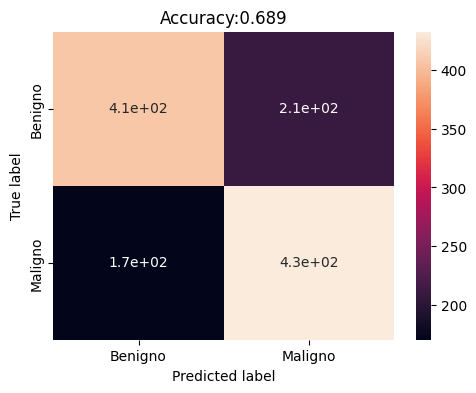

In [96]:
# Creates a confusion matrix
cm = metrics.confusion_matrix(y_test, y_test_pred)
accuracy = metrics.accuracy_score(y_test, y_test_pred)
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Benigno','Maligno'],
                     columns = ['Benigno','Maligno'])
plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Accuracy:{0:.3f}'.format(accuracy))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

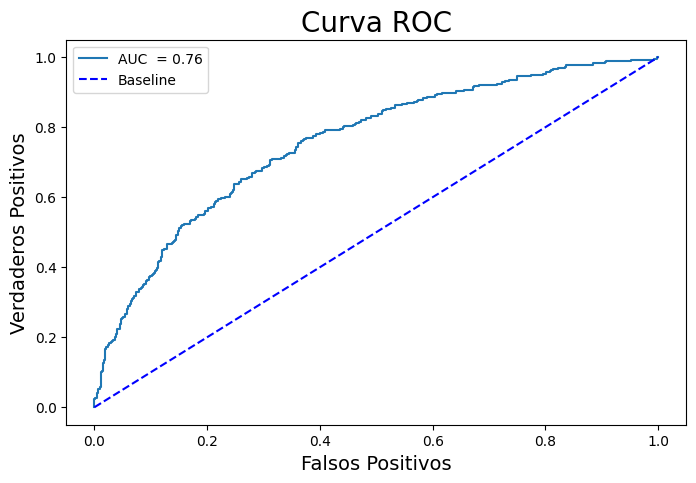

In [97]:
#Obtenemos las curva ROC y el área bajo la curva (AUC)

probs = modelo_final.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend();